# **Import libraries**

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import Xception
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import BatchNormalization, Dropout
import numpy as np
import cv2
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pickle
import json


# **Separating the data into the Subfolders**

In [ ]:
source_dir = '/content/drive/MyDrive/Project/AutismDataset/train'
autistic_dir = os.path.join(source_dir, 'autistic')
non_autistic_dir = os.path.join(source_dir, 'non_autistic')

os.makedirs(autistic_dir, exist_ok=True)
os.makedirs(non_autistic_dir, exist_ok=True)

for filename in os.listdir(source_dir):
    if filename.startswith('Autistic'):
        shutil.move(os.path.join(source_dir, filename), os.path.join(autistic_dir, filename))
    elif filename.startswith('Non_Autistic'):
        shutil.move(os.path.join(source_dir, filename), os.path.join(non_autistic_dir, filename))

print("Images have been separated into subfolders.")

In [ ]:
source_dir = '/content/drive/MyDrive/Project/AutismDataset/test'
autistic_dir = os.path.join(source_dir, 'autistic')
non_autistic_dir = os.path.join(source_dir, 'non_autistic')

os.makedirs(autistic_dir, exist_ok=True)
os.makedirs(non_autistic_dir, exist_ok=True)

for filename in os.listdir(source_dir):
    if filename.startswith('Autistic'):
        shutil.move(os.path.join(source_dir, filename), os.path.join(autistic_dir, filename))
    elif filename.startswith('Non_Autistic'):
        shutil.move(os.path.join(source_dir, filename), os.path.join(non_autistic_dir, filename))

print("Images have been separated into subfolders.")


# **Count the data and make sure of its balance**

In [ ]:
import os


autistic_dir = '/content/drive/MyDrive/project/train/autistic'
non_autistic_dir = '/content/drive/MyDrive/project/train/non_autistic'
num_autistic = len(os.listdir(autistic_dir))
num_non_autistic = len(os.listdir(non_autistic_dir))

print(f"Number of Autistic images: {num_autistic}")
print(f"Number of Non-Autistic images: {num_non_autistic}")

if num_autistic > 0:
    ratio = num_non_autistic / num_autistic
    print(f"Non-Autistic to Autistic Ratio: {ratio:.2f}")
else:
    print("No images found in the Autistic folder.")


Number of Autistic images: 1470
Number of Non-Autistic images: 1470
Non-Autistic to Autistic Ratio: 1.00


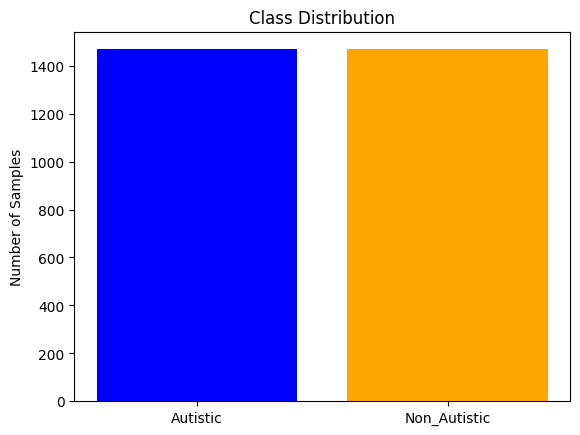

In [ ]:
import matplotlib.pyplot as plt


labels = ['Autistic', 'Non_Autistic']
counts = [num_autistic, num_non_autistic]

plt.bar(labels, counts, color=['blue', 'orange'])
plt.title('Class Distribution')
plt.ylabel('Number of Samples')
plt.show()


# **Preprocessing for Training images**

#### **Normalizing and Rescaling**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,

)
train_data_dir = '/content/drive/MyDrive/project/train'
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(299, 299),
    batch_size=64,
    class_mode='binary'
)

datagen = ImageDataGenerator(
    rescale=1./255,

)

valid_data_dir = '/content/drive/MyDrive/project/valid'

validation_generator = datagen.flow_from_directory(
    valid_data_dir,
    target_size=(299, 299),
    batch_size=64,
    class_mode='binary',
    shuffle=True
)




Found 2940 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


# **Xception Model**
![image.png](attachment:image.png)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import Xception
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization, Dropout

learning_rate = 0.001

def create_xception_model(input_shape=(299, 299, 3), num_classes=2):

    base_model = Xception(weights='imagenet', include_top=False, input_shape=input_shape)



    for layer in base_model.layers[-20:]:
        layer.trainable = True


    x = base_model.output


    x = layers.GlobalAveragePooling2D()(x)



    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = BatchNormalization(momentum=0.7)(x)
    x = Dropout(0.3)(x)


    output = layers.Dense(num_classes, activation='softmax')(x)


    model = models.Model(inputs=base_model.input, outputs=output)

    return model


model = create_xception_model()

model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 299, 299, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 149, 149, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 149, 149, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 149, 149, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 147, 147, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 147, 147, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 147, 147, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 147, 147, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 147, 147, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 147, 147, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 147, 147, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 147, 147, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 74, 74, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 74, 74, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 21,387,562 (81.59 MB)

 Trainable params: 21,332,522 (81.38 MB)

 Non-trainable params: 55,040 (215.00 KB)

# **Training Process**


In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping


checkpoint = ModelCheckpoint('autism_detection_model_(9.3).keras', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=15,
                    callbacks=[checkpoint, early_stopping],
                    verbose=1)


Epoch 1/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.7024 - loss: 4.8451 - val_accuracy: 0.7300 - val_loss: 3.4894
Epoch 2/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.9044 - loss: 2.3938 - val_accuracy: 0.6400 - val_loss: 3.0826
Epoch 3/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.9457 - loss: 1.2225 - val_accuracy: 0.7900 - val_loss: 1.3941
Epoch 4/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.9821 - loss: 0.6163 - val_accuracy: 0.7800 - val_loss: 1.3747
Epoch 5/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.9818 - loss: 0.3453 - val_accuracy: 0.8300 - val_loss: 0.7332
Epoch 6/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.9699 - loss: 0.2325 - val_accuracy: 0.7300 - val_loss: 1.3980
Epoch 7/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.9691 - loss: 0.1759 - val_accuracy: 0.8300 - val_loss: 0.6754
Epoch 8/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.9747 - loss: 0.1244 - val_accuracy: 0.8300 - val_lo

# **Testing Process**

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

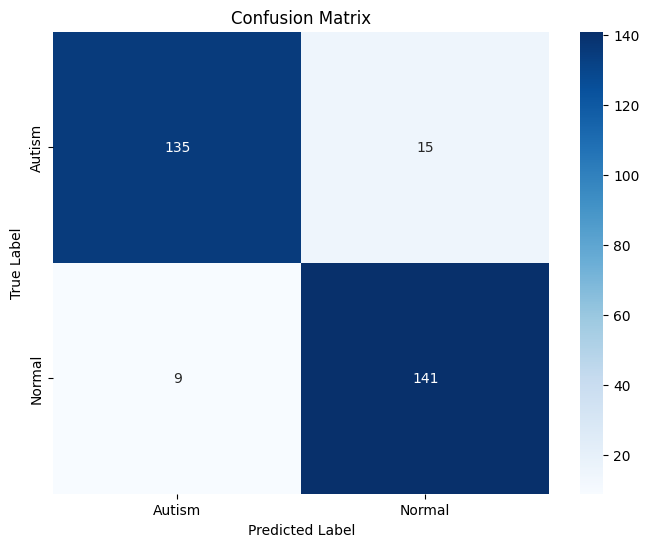

              precision    recall  f1-score   support

      Autism       0.94      0.90      0.92       150
      Normal       0.90      0.94      0.92       150

    accuracy                           0.92       300
   macro avg       0.92      0.92      0.92       300
weighted avg       0.92      0.92      0.92       300



In [10]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def preprocess_image(image_path, target_size=(299, 299)):
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = image / 255.0
    return image


def predict_on_test_set(model, test_dir):
    true_labels = []
    predictions = []

    for label in ['autistic', 'non_autistic']:
        label_dir = os.path.join(test_dir, label)
        for filename in os.listdir(label_dir):
            if filename.endswith('.jpg') or filename.endswith('.png'):
                image_path = os.path.join(label_dir, filename)


                image = preprocess_image(image_path)


                prediction = model.predict(image)[0]
                predicted_class = np.argmax(prediction)


                true_labels.append(0 if label == 'autistic' else 1)  # 0 for Autism, 1 for Normal
                predictions.append(predicted_class)

    return true_labels, predictions


test_dir = '/content/drive/MyDrive/project/test'
true_labels, predictions = predict_on_test_set(model, test_dir)


cm = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Autism', 'Normal'], yticklabels=['Autism', 'Normal'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


target_names = ['Autism', 'Normal']


print(classification_report(true_labels, predictions, target_names=target_names))


# **Save Model**

In [ ]:
model.save('autism_detection_model_(9.4).h5')

with open('model_architecture_(9.4).json', 'w') as json_file:
    json_file.write(model.to_json())


import pickle


with open('history_(9.4).pkl', 'wb') as f:
    pickle.dump(history.history, f)


model.save_weights('autism_detection_model_(9.4).weights.h5')  # Save just the weights

In [ ]:
import pickle


with open('history_(9.4).pkl', 'rb') as f:
    history = pickle.load(f)



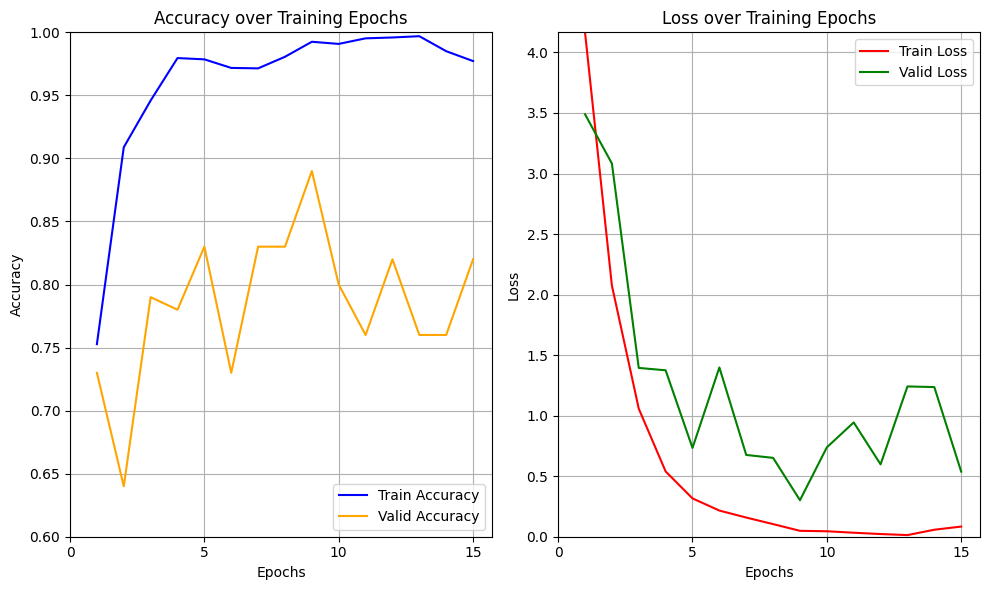

In [ ]:
import json
import matplotlib.pyplot as plt


epochs = range(1, len(history['accuracy']) + 1)


train_accuracy = history['accuracy']
valid_accuracy = history['val_accuracy']


train_loss = history['loss']
valid_loss = history['val_loss']


plt.figure(figsize=(10, 6))

# Accuracy plot
plt.subplot(1, 2, 1)  #  (1 row, 2 columns, 1st plot)
plt.plot(epochs, train_accuracy, label='Train Accuracy', color='blue', linestyle='-')
plt.plot(epochs, valid_accuracy, label='Valid Accuracy', color='orange', linestyle='-')
plt.title('Accuracy over Training Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.yticks([i / 100 for i in range(60, 101, 5)])  # Y-axis ticks from 0.60 to 1.00
plt.ylim(0.60, 1)  # Set y-axis limit starting at 0.60
plt.xticks(range(0, len(epochs) + 5, 5))  # X-axis ticks every 5 epochs
plt.legend()
plt.grid()

# Plotting Loss
plt.subplot(1, 2, 2)  # (1 row, 2 columns, 2nd plot)
plt.plot(epochs, train_loss, label='Train Loss', color='red', linestyle='-')
plt.plot(epochs, valid_loss, label='Valid Loss', color='green', linestyle='-')
plt.title('Loss over Training Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, max(max(train_loss), max(valid_loss)))  # Automatically scale the y-axis for loss
plt.xticks(range(0, len(epochs) + 5, 5))  # X-axis ticks every 5 epochs
plt.legend()
plt.grid()


plt.tight_layout()


plt.show()


# **User Input**

In [ ]:
from tensorflow.keras.models import load_model
model_path = 'autism_detection_model_(9.4).h5'
model = load_model(model_path)

